# Historical Data: Intraday

These financial data are generally provided in a format that includes the following information:  
- Date  
- Open Price  
- High Price  
- Low Price  
- Closing Price  
- Volume  
These data—often referred to as OHLC Chart Data—can be interpreted as Time Series data and are perfect for performing technical analysis. We’ll dive into this format in just a moment but, for now, just realize this is a standard format for historical pricing data within financial markets.

## Import libraries

In [1]:
import yfinance as yf
import os
import pandas as pd
from matplotlib import pyplot as plt
from io import StringIO
import requests
import seaborn as sns
import numpy as np

## Extracting ticker codes
Extracting ticker codes of yfinance and EODhistoricaldata of same companies.

In [2]:
os.environ['EOD_API_KEY']='6327e5ab358c70.29416475'

In [3]:
'''Extracting ticker of eodhistoricaldata.'''
api_key = os.environ['EOD_API_KEY']

class NoSuchExchange(Exception):
    def __init__(self, message: str= "No such exhange supported."):
        self.message = message
        super().__init__(message)

def get_ticker_list(exchange, api_token, session=None):
    """Returns a df of tickers available in EODhistorical data."""
    if exchange not in ['BSE', 'NSE']:
        raise NoSuchExchange()
    
    if session is None:
        session=requests.Session()
        url = 'https://eodhistoricaldata.com/api/exchange-symbol-list/%s' % exchange
        params = {'api_token': api_token}
        r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df

In [4]:
file = 'Yahoo Ticker Symbols - September 2017.xlsx'                                             #file that contains ticker list of yfinance.
df = pd.read_excel(os.path.abspath(file), sheet_name='Stock')
ticker_list1 = get_ticker_list('BSE', api_key)                                                  #extracting BSE tickers from EOD ticker list.
name_list=ticker_list1['Name']
df_BSE = df[df['Unnamed: 2'] == 'BSE']                                                          #extracting BSE tickers from yfinance ticker list.
ticker = df_BSE[df_BSE['Unnamed: 1'].isin(name_list)].head(30)                                  # filtering common companies in both ticker lists.
extra_name = ticker_list1[ticker_list1['Name'].isin(ticker['Unnamed: 1'])].reset_index()        
yfinance_ticker = ticker['Yahoo Stock Tickers'].reset_index(drop=True)                          # getting ticker codes of common companies of yfinance.
yfinance_company = ticker['Unnamed: 1'].reset_index(drop=True)                                  # getting company name of common companies of yfinance.
eod_ticker = extra_name['Code'].reset_index(drop=True)                                          # getting ticker codes of common companies of eodhistoricaldata.
eod_company = extra_name['Name'].reset_index(drop=True)                                         # getting company names of common companies of eodhistoricaldata.

## Download yfinance historical data

In [5]:
# download historical data of yfinance
yfinance_dict = {}
for i in range(30):
    yfinance_dict[yfinance_company[i]] = yf.download(yfinance_ticker[i], period='max')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Extract EODHistoricaldata

In [6]:
def get_eod_data(symbol, api_token="xxxx", session=None):
    '''returns a df of historical data.'''
    if session is None:
        session = requests.Session()
        url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
        params = {"api_token": api_token}
        r = session.get(url, params=params)

    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df


api_key = api_key = os.environ['EOD_API_KEY']
eod_dict = {}
for i in range(29):
    eod_dict[eod_company[i]] = get_eod_data(eod_ticker[i]+'.BSE', api_key)


## Data Preprocessing
Checking is data contains null, duplicate values or not and data contains any outliers or not.

In [1]:
# Checking if data contains any outliers
def find_outliers(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return pd.DataFrame(outliers)

def data_preprocessing(df):
   """Returns a dictionary with the keys:
      null_values: the number of cells which contains null values.
      duplicated_values: the number of cells which contain duplicate values.
      commont_stats: describe the data like mean, median, max, min
      outliers: the no. of outliers data contains and min amd max outlier in particular field.
   """

   null_values = df.isna().sum()                      # checking if data contains any null values
   duplicate_values = df.duplicated()                 # checking if data contains any duplicate values
   common_stats = df.describe()                       # checking common stats of data
   outliers = find_outliers(df)                       # finding outliers in data

   dict = {'null_values':null_values, 'duplicate_values':duplicate_values, 'common_stats':common_stats, 'outliers':outliers}
   return dict

In [383]:
"""Checking EOD and yfinance Data. """
data_preprocessing_eod = {}
data_preprocessing_yfinance = {}
for company in eod_dict.keys():
    data_preprocessing_eod[company] = data_preprocessing(eod_dict[company])
    data_preprocessing_yfinance[company] = data_preprocessing(yfinance_dict[company])

In [ ]:
data_preprocessing_eod

In [ ]:
data_preprocessing_yfinance

## Data wrangling
Finding differences in data and combining open, close, high, low and volume values of different companies together.

In [7]:
def data_convert(dict):
    """Returns a list of dataframes with yearly calculated stock data of different companies together of different fields."""
    data = {}
    for company in eod_company:
        try:
            data[company] = dict[company]
            data[company]['date'] = pd.to_datetime(data[company].index)
            data[company].set_index('date', inplace=True)
            data[company].index = pd.to_datetime(data[company].index)
            data[company] = data[company].resample('A').last()
        except KeyError as e:
            pass

    res = pd.concat(data.values(), axis=1, keys=data.keys())

    open = {}
    close = {}
    high = {}
    low = {}
    volume = {}
    for company in data.keys():
        open[company] = res[company]['Open']
        close[company] = res[company]['Close']
        high[company] = res[company]['High']
        low[company] = res[company]['Low']
        volume[company] = res[company]['Volume']

    res_open = pd.DataFrame(open)
    res_close = pd.DataFrame(close)
    res_high = pd.DataFrame(high)
    res_low = pd.DataFrame(low)
    res_volume = pd.DataFrame(volume)

    return [res_open, res_close, res_high, res_low, res_volume]

In [8]:
eod_list = data_convert(eod_dict)
yfinance_list=data_convert(yfinance_dict)
difference_in_data = {}
for company in eod_dict.keys():
    difference_in_data[company] = eod_dict[company] - yfinance_dict[company]

difference_in_data_list = data_convert(difference_in_data)

## Ploting the data
Let's plot the difference in the values of data provided by yfinance and EODhistorical of 30 companies.

### Plotting original data

#### Plotting Eodhistorical data
Plotting EODhistorical data of 30 companies values on yearly basis.

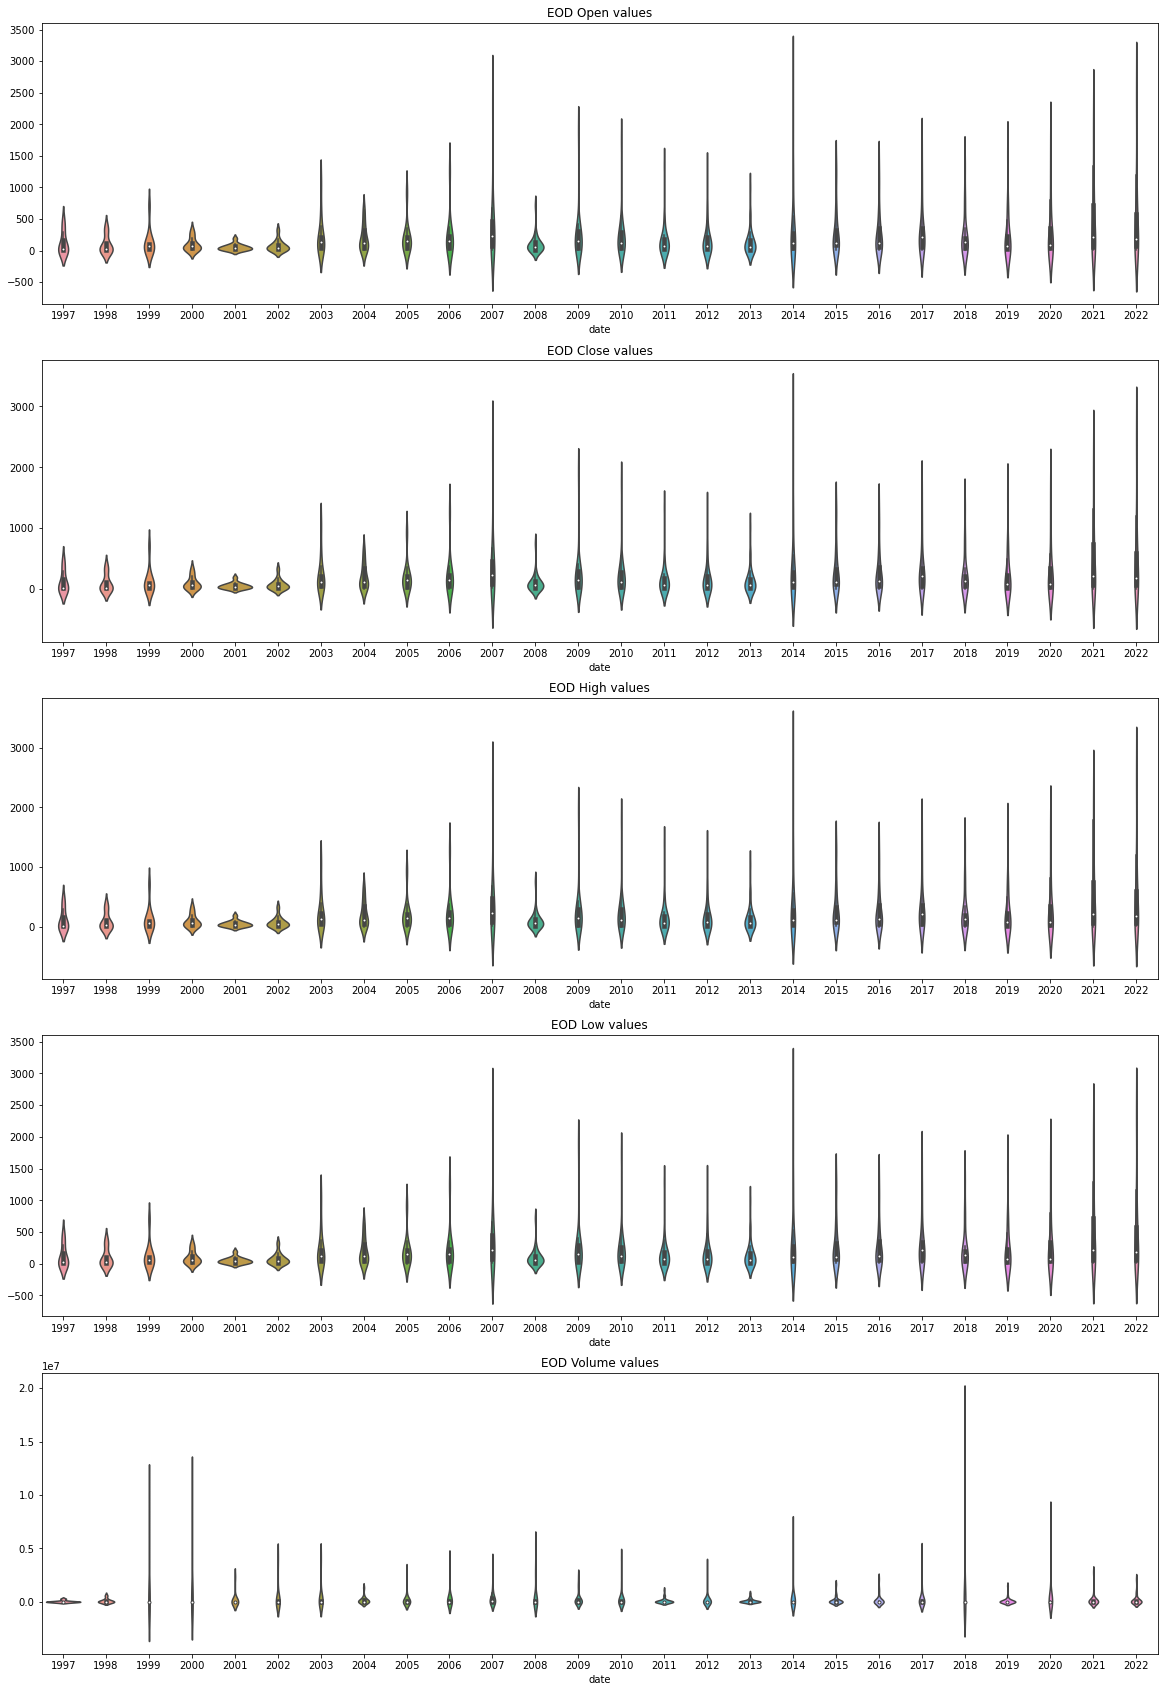

In [87]:
f, axes = plt.subplots(5, figsize = (20,30))

date=pd.DatetimeIndex(eod_list[0].index).year.to_list()
sns.violinplot(data=eod_list[0].T, ax=axes[0]).set(title='EOD Open values')
axes[0].set_xticks(np.arange(0, 26, 1), date)
sns.violinplot(data=eod_list[1].T, ax=axes[1]).set(title='EOD Close values')
axes[1].set_xticks(np.arange(0, 26, 1), date)
sns.violinplot(data=eod_list[2].T, ax=axes[2]).set(title='EOD High values')
axes[2].set_xticks(np.arange(0, 26, 1), date)
sns.violinplot(data=eod_list[3].T, ax=axes[3]).set(title='EOD Low values')
axes[3].set_xticks(np.arange(0, 26, 1), date)
sns.violinplot(data=eod_list[4].T, ax=axes[4]).set(title='EOD Volume values')
axes[4].set_xticks(np.arange(0, 26, 1), date)


#### Plotting Yfinance data
Plotting Yfinance data of 30 companies values on yearly basis.

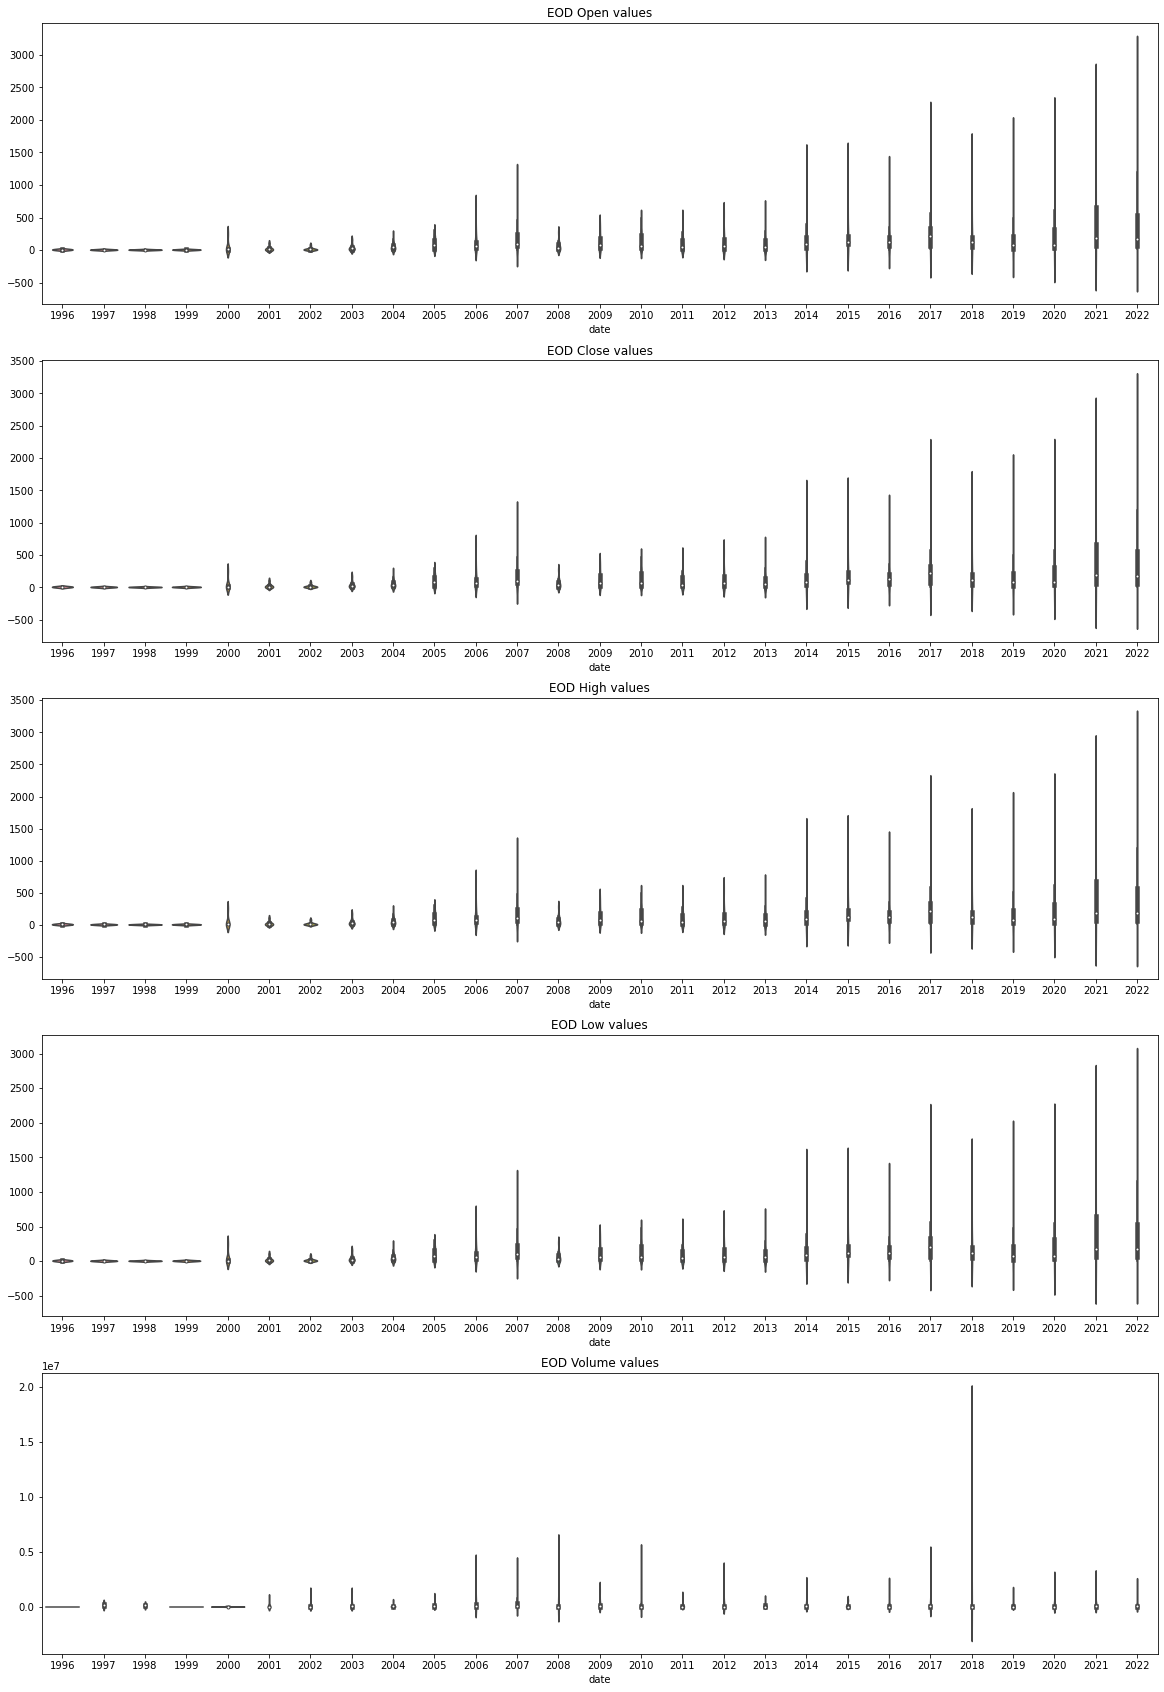

In [89]:
f, axes = plt.subplots(5, figsize = (20,30))

date1=pd.DatetimeIndex(yfinance_list[0].index).year.to_list()
sns.violinplot(data=yfinance_list[0].T, ax=axes[0]).set(title='EOD Open values')
axes[0].set_xticks(np.arange(0, 27, 1), date1)
sns.violinplot(data=yfinance_list[1].T, ax=axes[1]).set(title='EOD Close values')
axes[1].set_xticks(np.arange(0, 27, 1), date1)
sns.violinplot(data=yfinance_list[2].T, ax=axes[2]).set(title='EOD High values')
axes[2].set_xticks(np.arange(0, 27, 1), date1)
sns.violinplot(data=yfinance_list[3].T, ax=axes[3]).set(title='EOD Low values')
axes[3].set_xticks(np.arange(0, 27, 1), date1)
sns.violinplot(data=yfinance_list[4].T, ax=axes[4]).set(title='EOD Volume values')
axes[4].set_xticks(np.arange(0, 27, 1), date1)


### Covariance
Heatmap of open, close, low, high and volume of 30 companies of yearly data of difference in the values in the data provided by the eodhistoricaldata and yfinance.

#### Heatmap of Open values

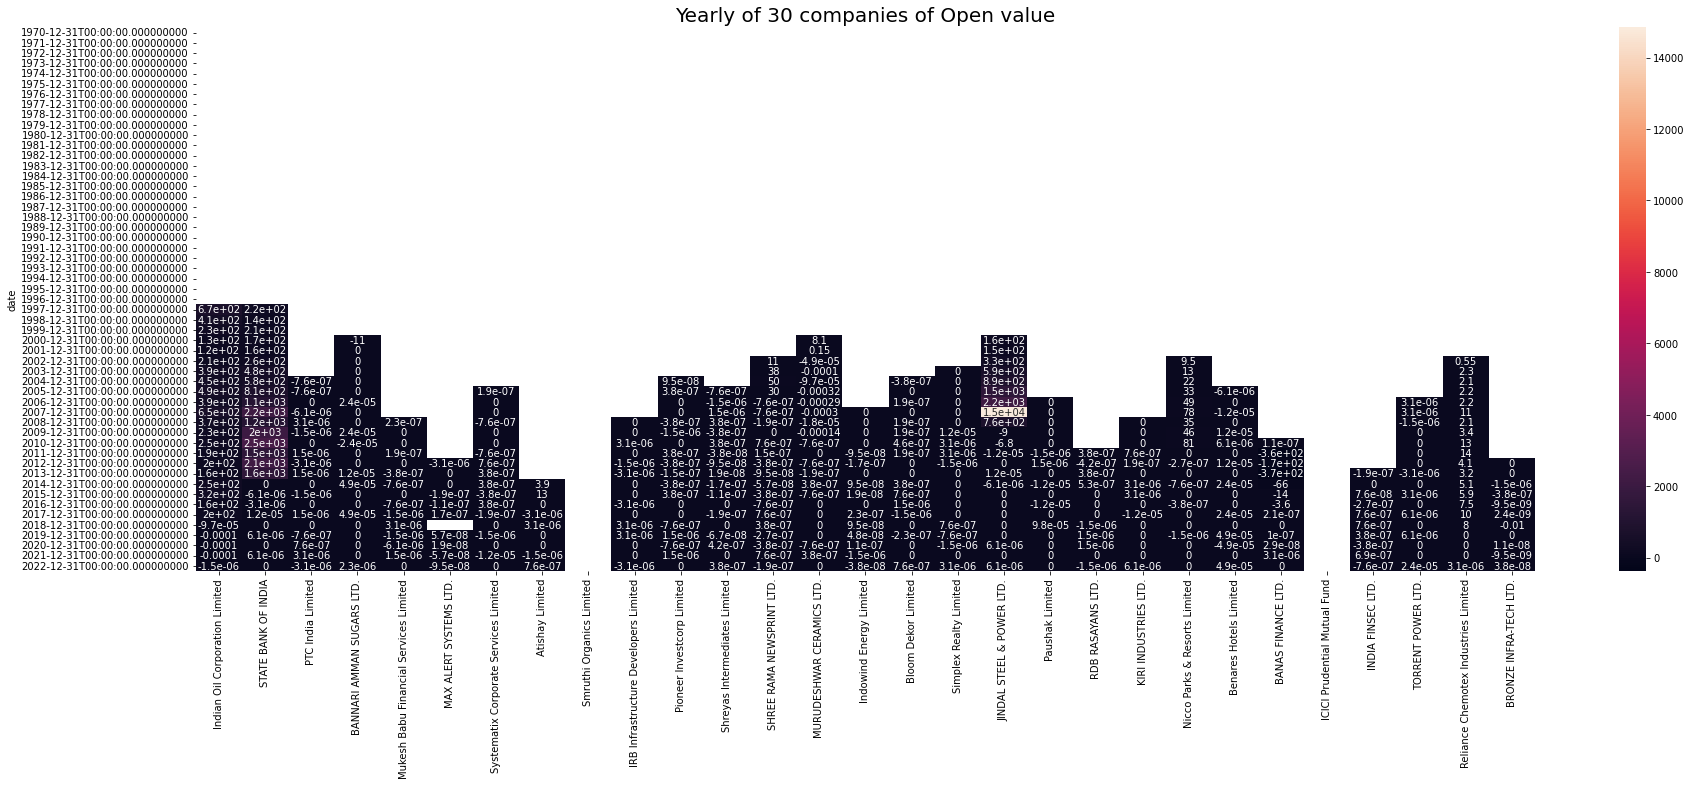

In [358]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[0] , annot = True)
plt.title('Yearly of 30 companies of Open value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Close values

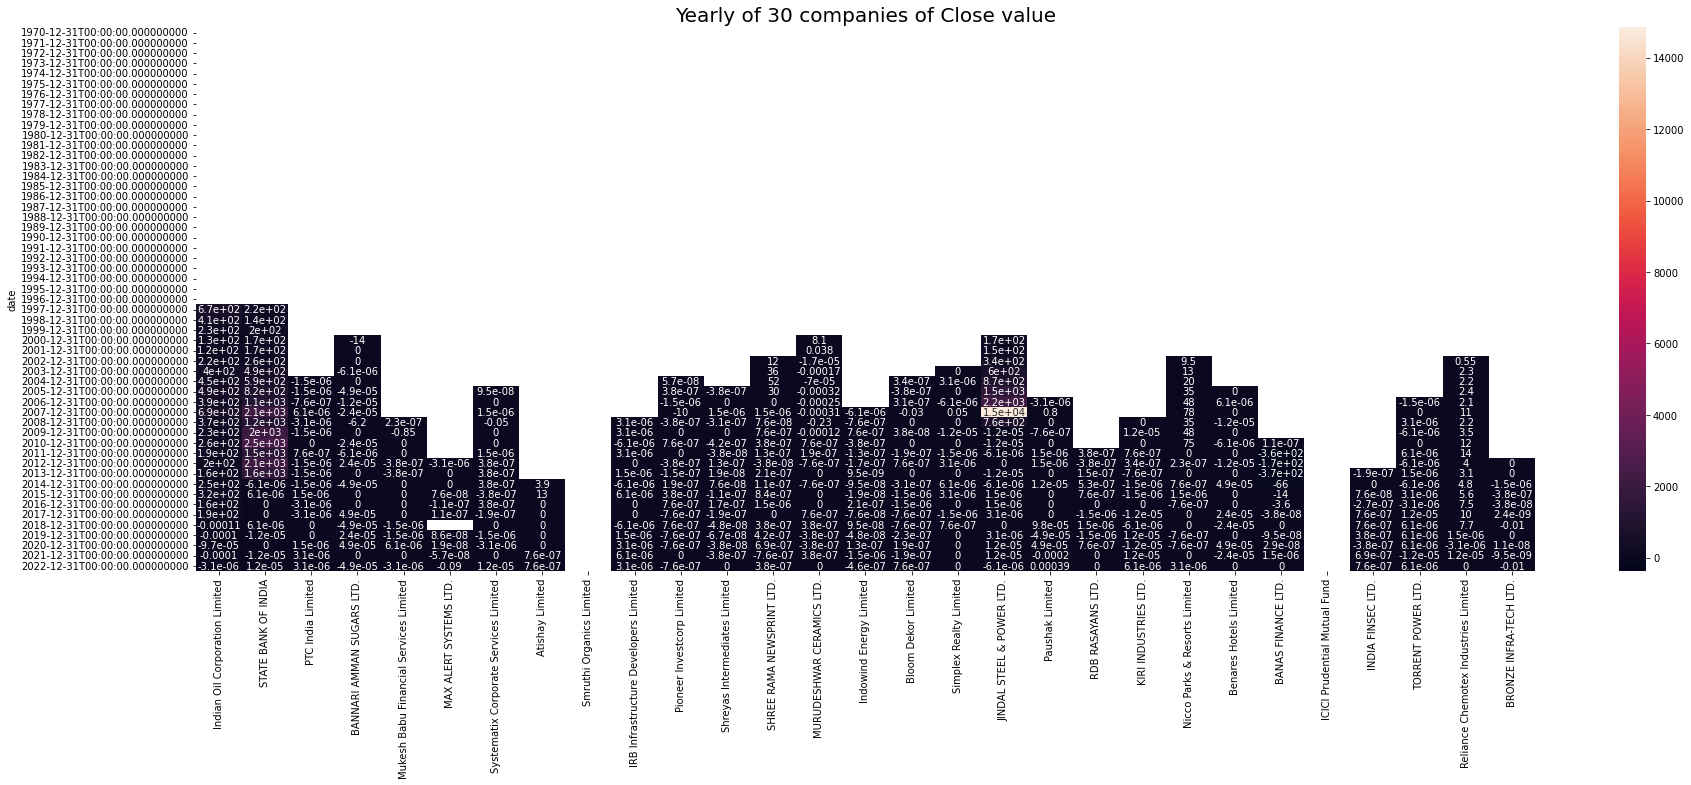

In [361]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[1] , annot = True)
plt.title('Yearly of 30 companies of Close value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of High values

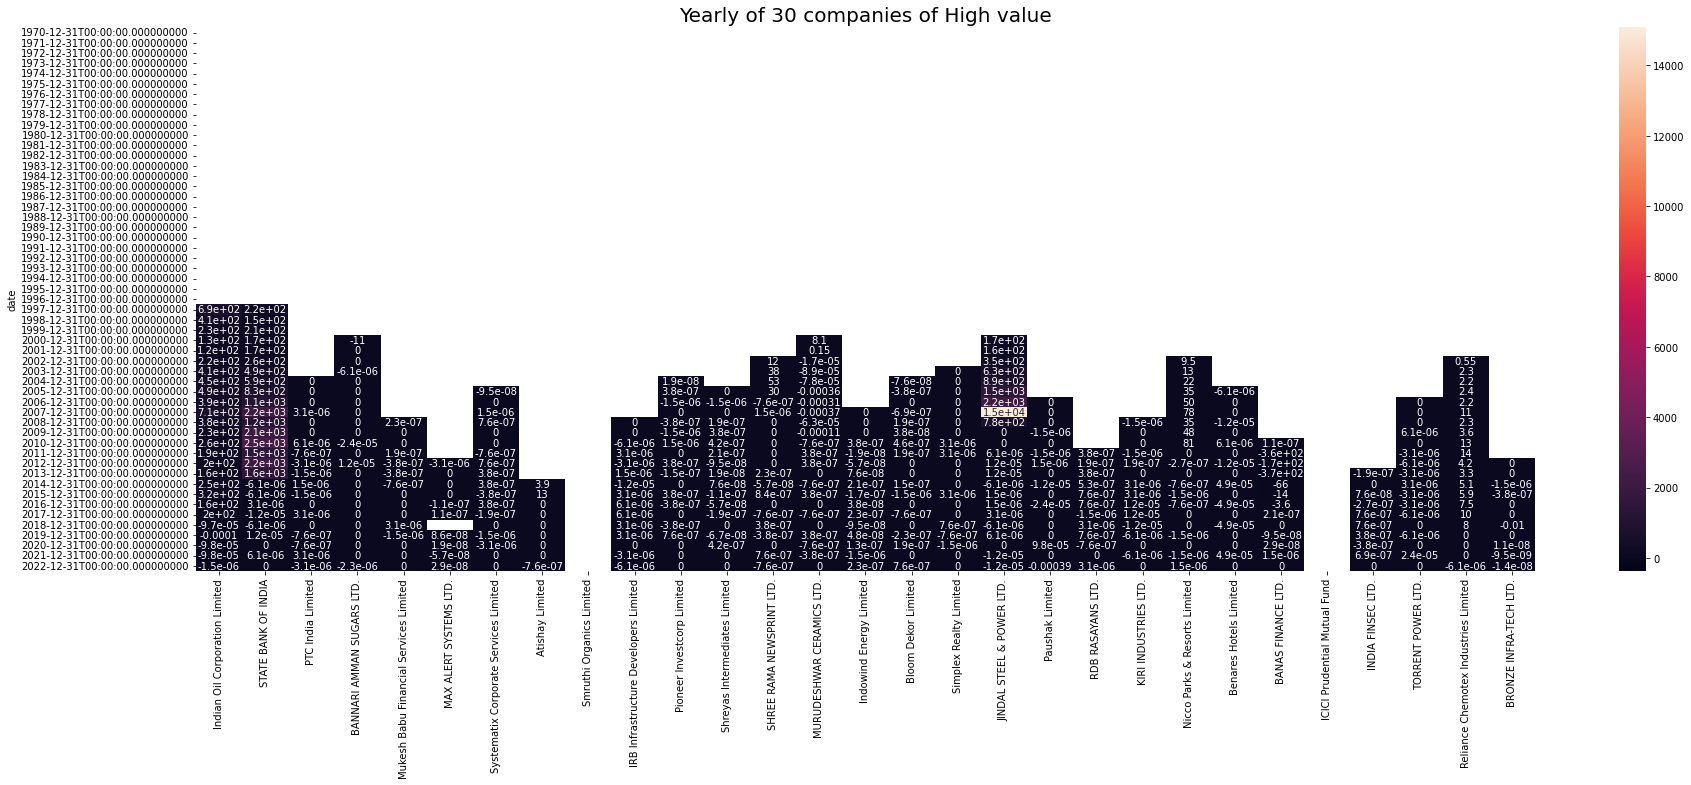

In [359]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[2] , annot = True)
plt.title('Yearly of 30 companies of High value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Low values

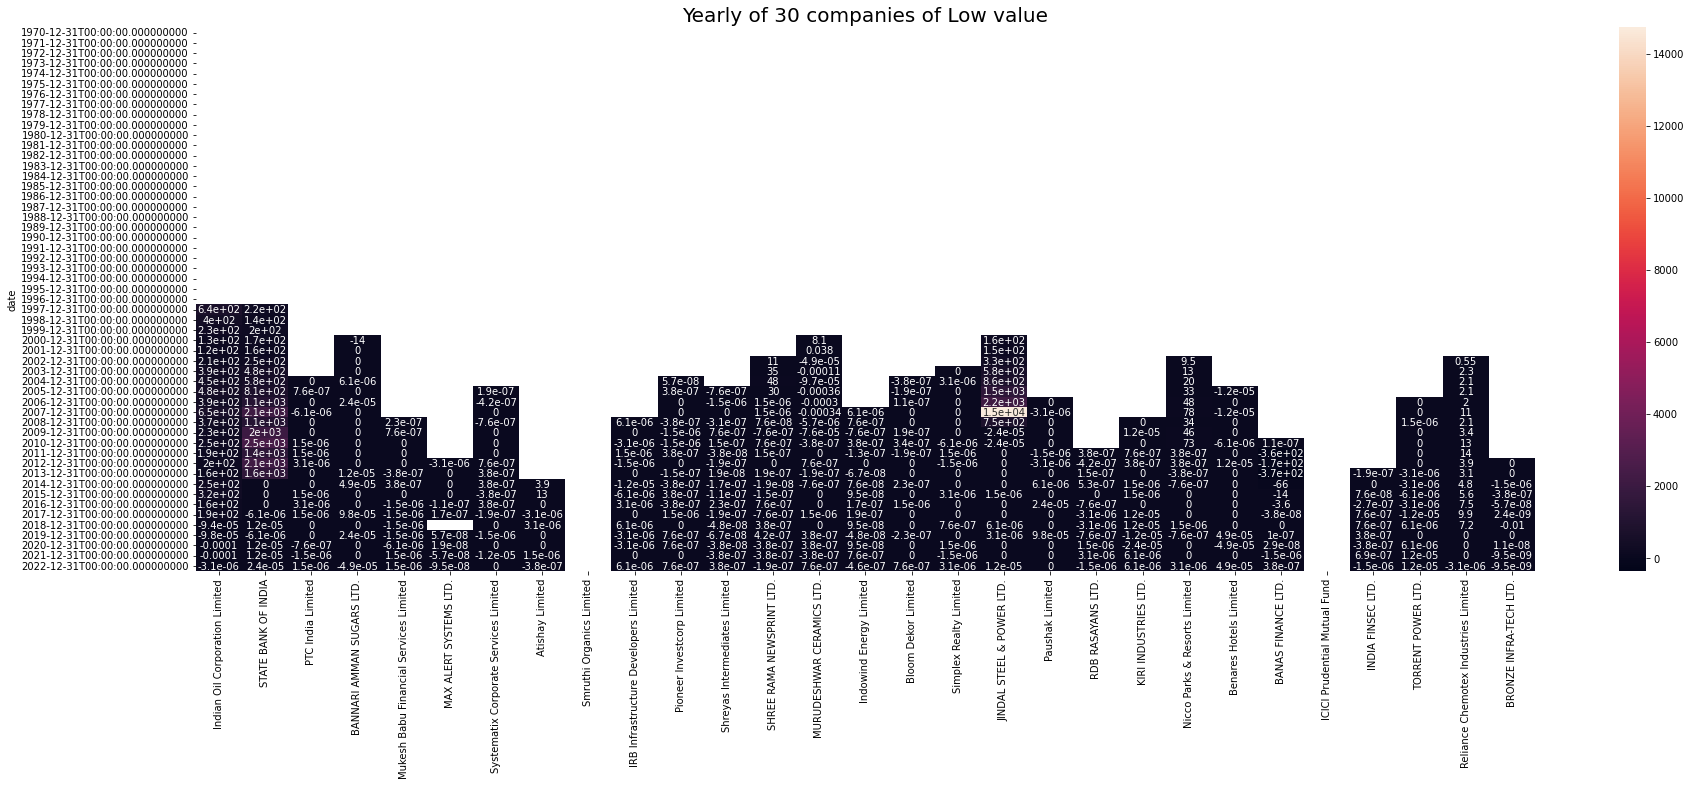

In [360]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[3] , annot = True)
plt.title('Yearly of 30 companies of Low value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Volume values

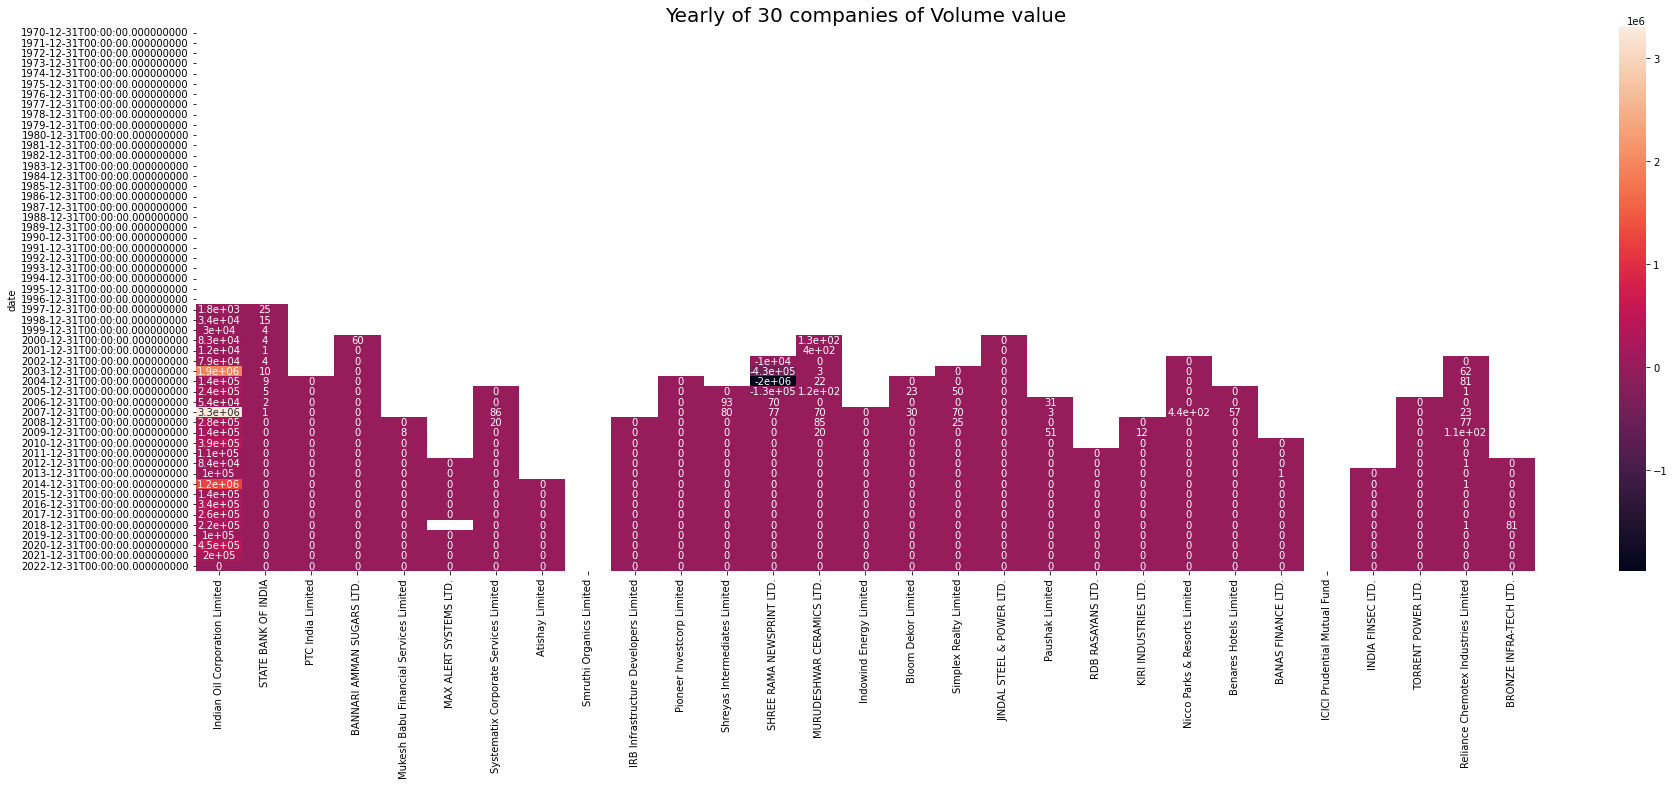

In [ ]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(difference_in_data_list[5] , annot = True)
plt.title('Yearly of 30 companies of Volume value', fontdict={'fontsize':20})
plt.show()

### Exploring correlaltion among data
Here, we will explore correlation among data using correlation matrix then we will plot that on heatmap.

#### Correlation plot for open values

<Figure size 2160x720 with 0 Axes>

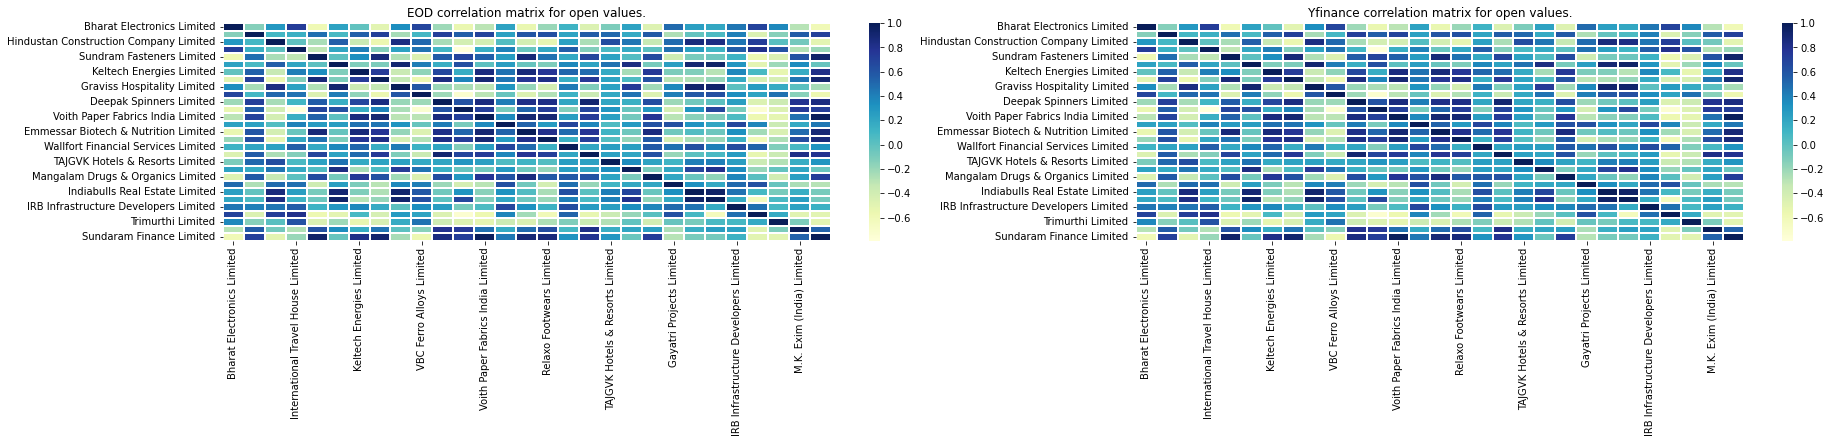

In [60]:
corrmat = eod_list[0].corr()
corrmat2 = yfinance_list[0].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for open values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for open values.')
plt.subplots_adjust(right=4.0)

#### Correlation plot for close values

<Figure size 2160x720 with 0 Axes>

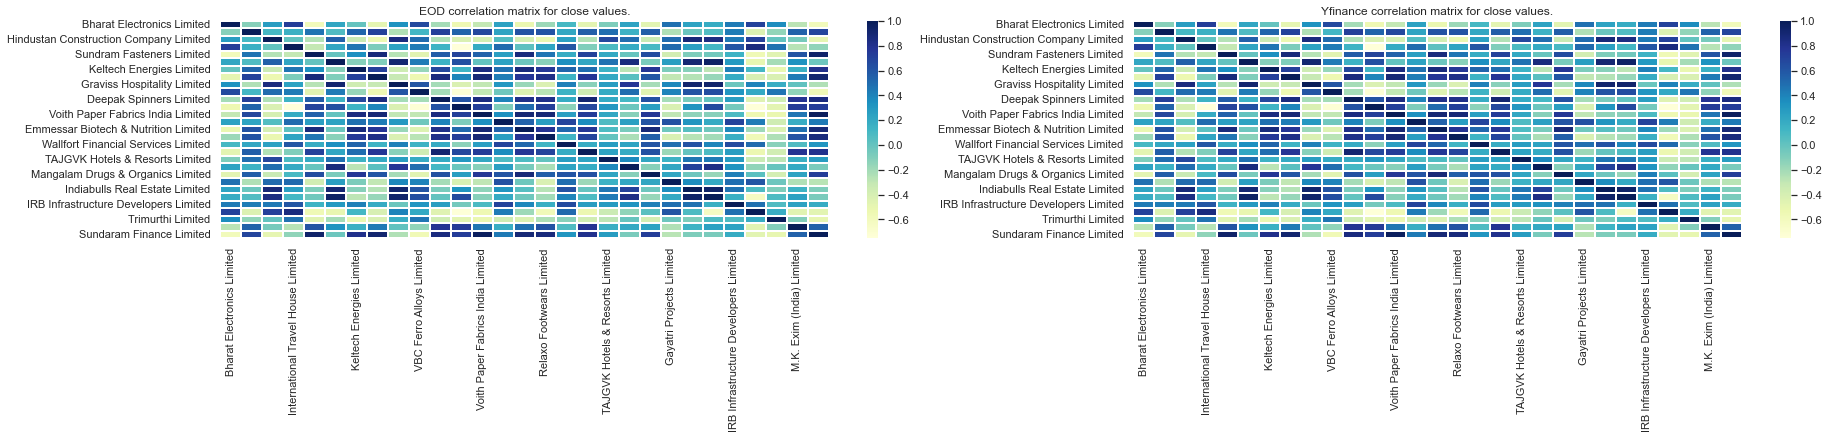

In [224]:
corrmat = eod_list[1].corr()
corrmat2 = yfinance_list[1].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for close values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for close values.')
plt.subplots_adjust(right=4.0)

#### Correlation plot for high values

<Figure size 2160x720 with 0 Axes>

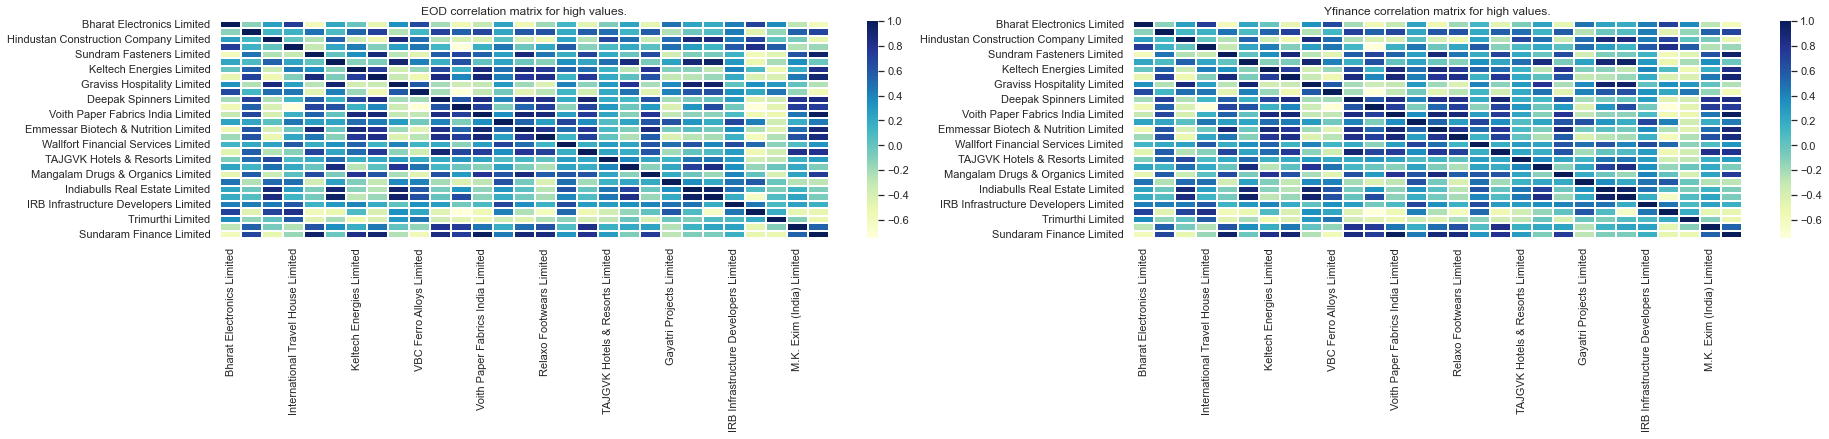

In [225]:
corrmat = eod_list[2].corr()
corrmat2 = yfinance_list[2].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for high values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for high values.')
plt.subplots_adjust(right=4.0)

#### Correlation plot for low values

<Figure size 2160x720 with 0 Axes>

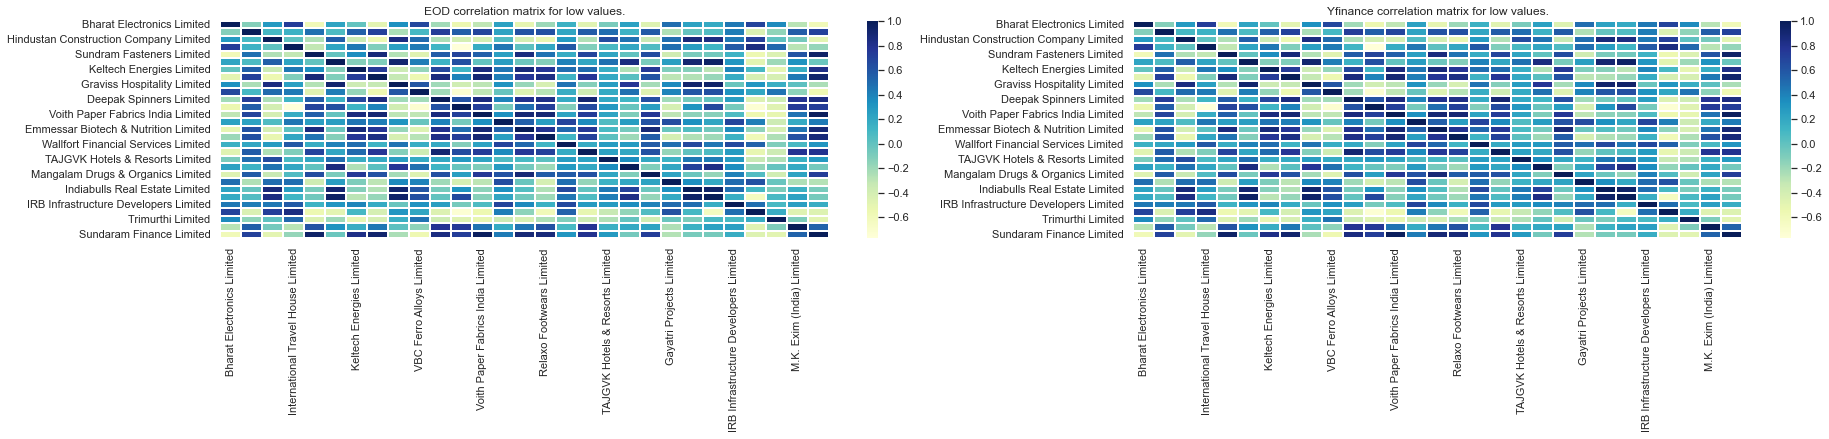

In [228]:
corrmat = eod_list[3].corr()
corrmat2 = yfinance_list[3].corr()
plt.figure(figsize=(30,10))
f, ax = plt.subplots(1, 2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for low values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for low values.')
plt.subplots_adjust(right=4.0)

#### Correlation plot for volume values

<Figure size 720x2160 with 0 Axes>

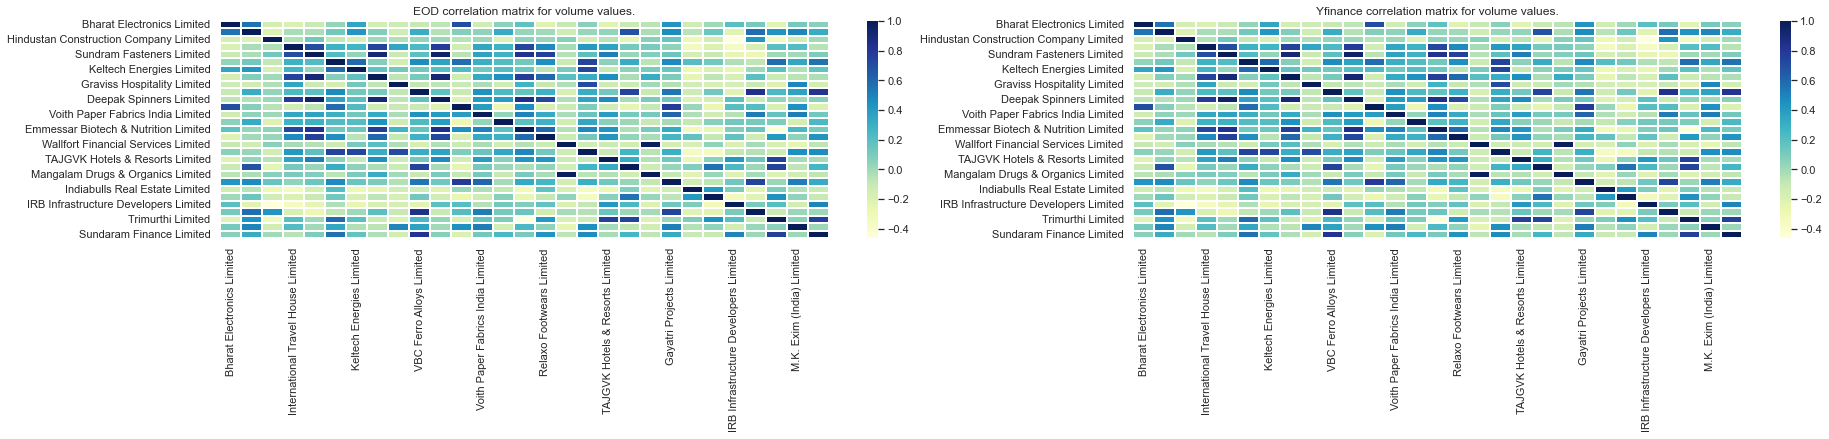

In [229]:
corrmat = eod_list[4].corr()
corrmat2 = yfinance_list[4].corr()
plt.figure(figsize=(10,30))
f, ax = plt.subplots(1,2)
sns.heatmap(corrmat, ax = ax[0], cmap ="YlGnBu", linewidths = 0.1).set(title='EOD correlation matrix for volume values.')
sns.heatmap(corrmat, ax = ax[1], cmap ="YlGnBu", linewidths = 0.1).set(title='Yfinance correlation matrix for volume values.')
plt.subplots_adjust(right=4.0)

### Histplot
Plotting the count of NAN values of yearly calculated data of each field of different sources.

#### Open values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\584187326.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


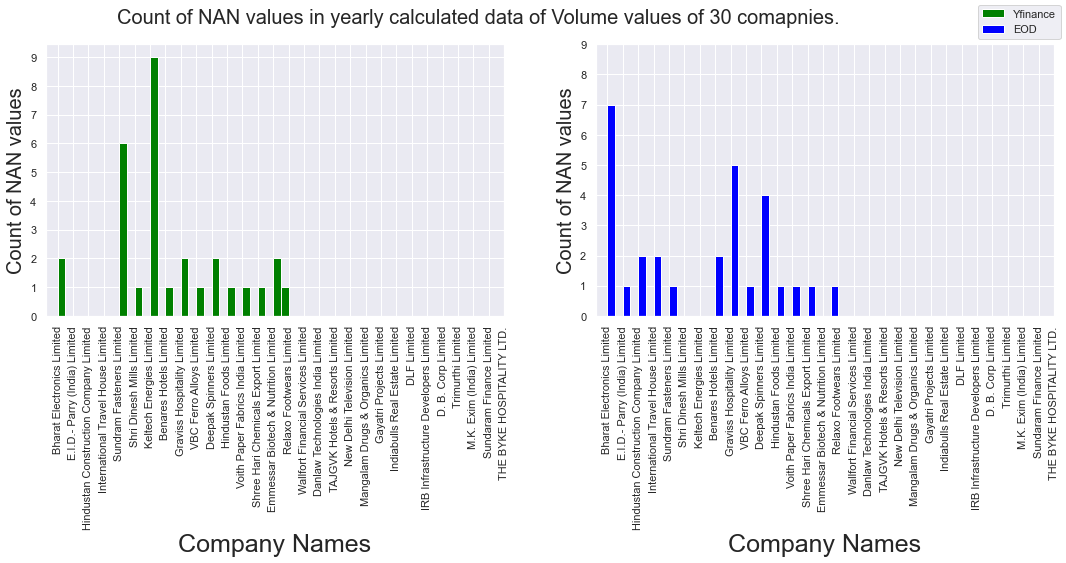

In [213]:
df = yfinance_list[0].isna().sum()
df = pd.DataFrame(df)
df1 = eod_list[0].isna().sum()
df1 = pd.DataFrame(df1)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df, color="green", bins=30)
l2 = ax2.hist(df1, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

####  Close Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\4247876057.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


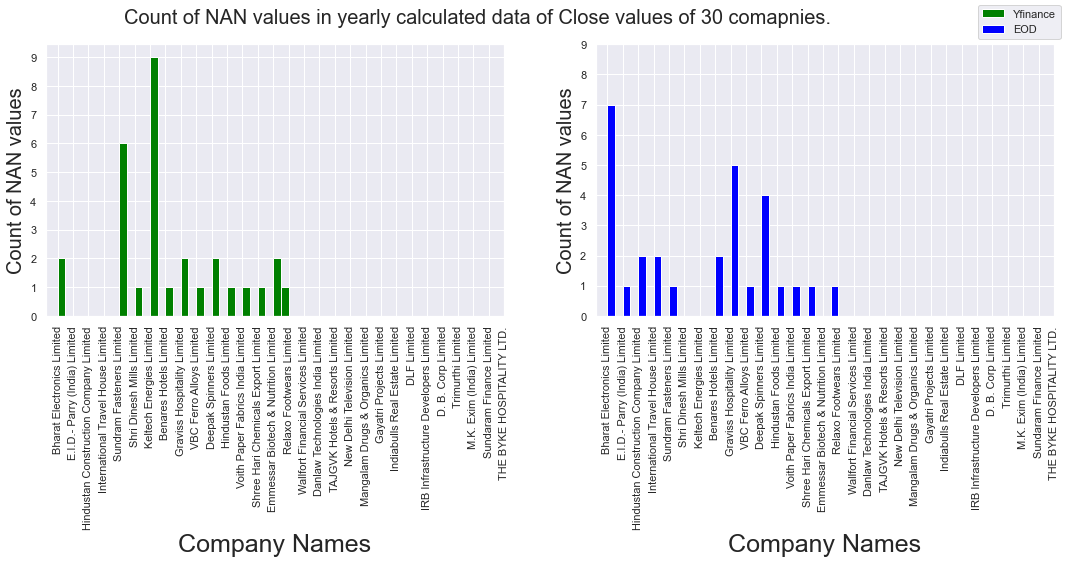

In [215]:
df3 = yfinance_list[1].isna().sum()
df3 = pd.DataFrame(df3)
df4 = eod_list[1].isna().sum()
df4 = pd.DataFrame(df4)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Close values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df3, color="green", bins=30)
l2 = ax2.hist(df4, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

#### High Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\1877719279.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


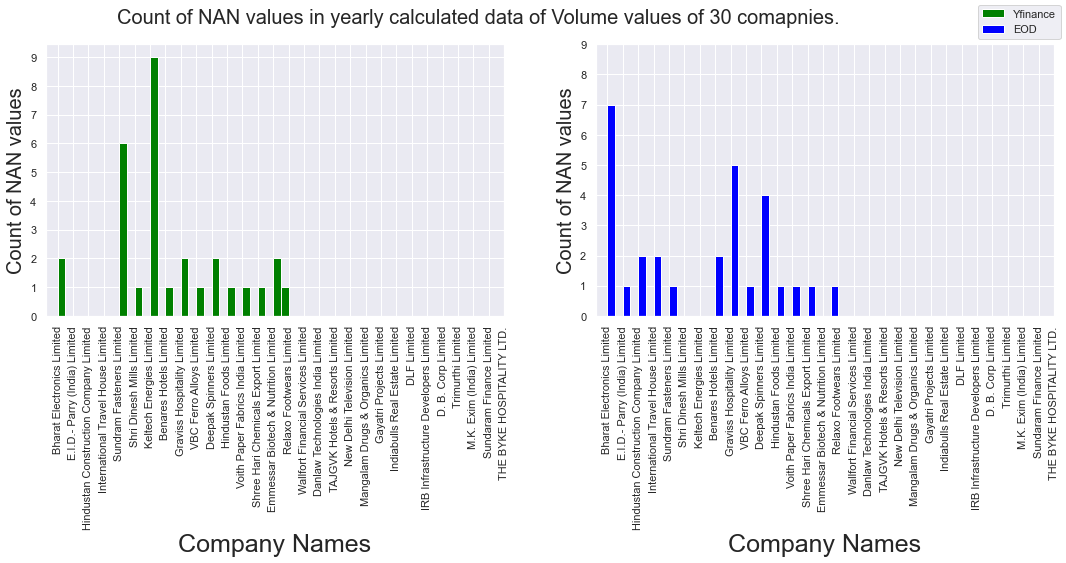

In [216]:
df5 = yfinance_list[2].isna().sum()
df5 = pd.DataFrame(df5)
df6 = eod_list[2].isna().sum()
df6 = pd.DataFrame(df6)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df5, color="green", bins=30)
l2 = ax2.hist(df6, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

#### Low Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\4230031498.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


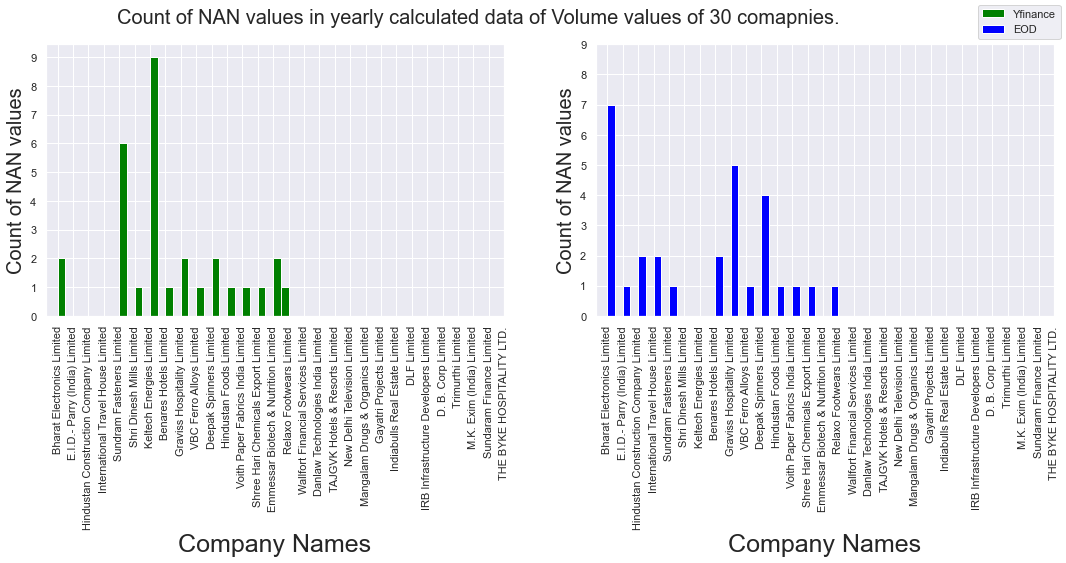

In [217]:
df7 = yfinance_list[3].isna().sum()
df7 = pd.DataFrame(df7)
df8 = eod_list[3].isna().sum()
df8 = pd.DataFrame(df8)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df7, color="green", bins=30)
l2 = ax2.hist(df8, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

#### Volume Values

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1508\3630915568.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc="upper right")


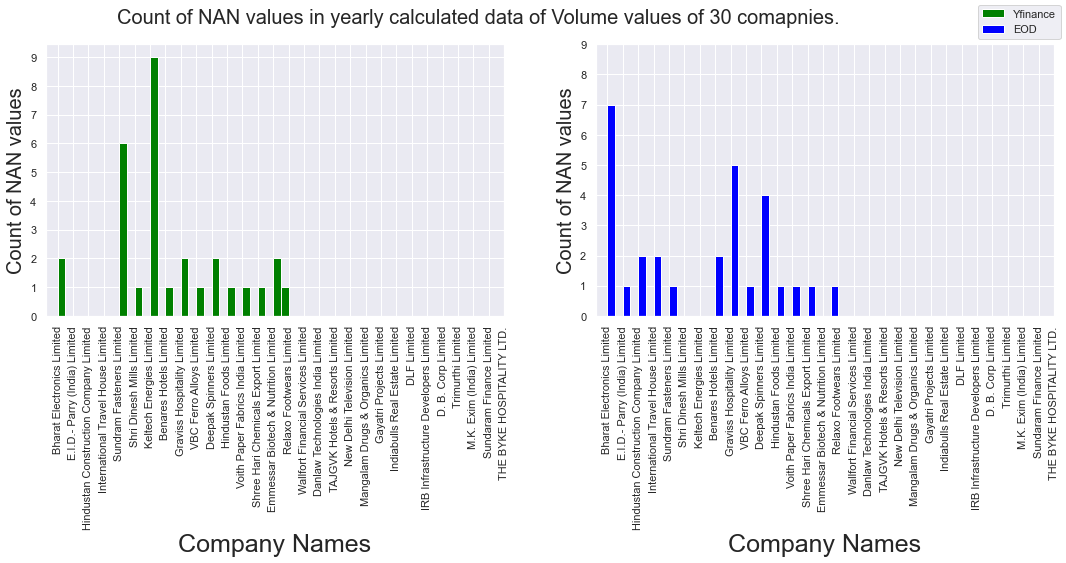

In [218]:
df9 = yfinance_list[4].isna().sum()
df9 = pd.DataFrame(df9)
df10 = eod_list[4].isna().sum()
df10 = pd.DataFrame(df10)

# 2 subplots in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
  
x1 = df.index

fig.suptitle('Count of NAN values in yearly calculated data of Volume values of 30 comapnies.', fontsize=20)
  
# Creating the sub-plots.
l1 = ax1.hist(df9, color="green", bins=30)
l2 = ax2.hist(df10, color="blue", bins=30)
  
ax1.set_yticks(np.arange(0, 10, 1))
ax1.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
ax2.set_yticks(np.arange(0, 10, 1))
ax2.set_xticks(np.arange(0, 30, 1), x1, rotation='vertical')
  
ax1.set_ylabel('Count of NAN values', fontsize=20)
ax1.set_xlabel('Company Names', fontsize=25)
ax2.set_ylabel('Count of NAN values', fontsize=20)
ax2.set_xlabel('Company Names', fontsize=25)
  
labels = ["Yfinance", "EOD"]
fig.legend([l1, l2], labels=labels, loc="upper right")
  
# Adjusting the sub-plots
plt.subplots_adjust(right=1.0)
  
plt.show()

### Exponential Moving Average of difference in values (EODhistoricaldata - yfinance)

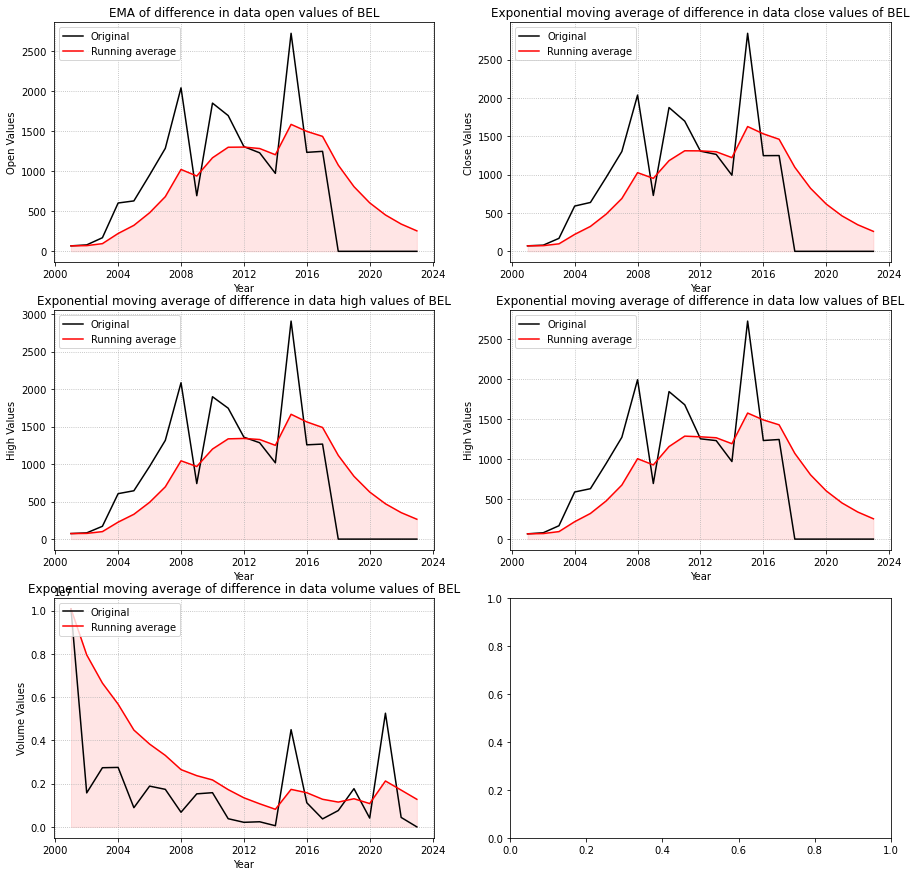

In [56]:
# Open values
open_values = difference_in_data_list[0]['Bharat Electronics Limited']
t_average = open_values.ewm(span=7, adjust=False).mean()
fig, ax = plt.subplots(3,2, figsize=(15, 15))
ax[0][0].plot(open_values, 'k-', label='Original')
ax[0][0].plot(t_average, 'r-', label='Running average')
ax[0][0].set_ylabel('Open Values')
ax[0][0].set_xlabel('Year')
ax[0][0].grid(linestyle=':')
ax[0][0].fill_between(t_average.index, 0, t_average, color='r', alpha=0.1)
ax[0][0].set_title('EMA of difference in data open values of BEL')
ax[0][0].legend(loc='upper left')

#close values
close_values = difference_in_data_list[1]['Bharat Electronics Limited']
t_average1 = close_values.ewm(span=7, adjust=False).mean()
ax[0][1].plot(close_values, 'k-', label='Original')
ax[0][1].plot(t_average1, 'r-', label='Running average')
ax[0][1].set_ylabel('Close Values')
ax[0][1].set_xlabel('Year')
ax[0][1].grid(linestyle=':')
ax[0][1].fill_between(t_average1.index, 0, t_average1, color='r', alpha=0.1)
ax[0][1].set_title('Exponential moving average of difference in data close values of BEL')
ax[0][1].legend(loc='upper left')

#high values
high_values = difference_in_data_list[2]['Bharat Electronics Limited']
t_average2 = high_values.ewm(span=7, adjust=False).mean()
ax[1][0].plot(high_values, 'k-', label='Original')
ax[1][0].plot(t_average2, 'r-', label='Running average')
ax[1][0].set_ylabel('High Values')
ax[1][0].set_xlabel('Year')
ax[1][0].grid(linestyle=':')
ax[1][0].fill_between(t_average2.index, 0, t_average2, color='r', alpha=0.1)
ax[1][0].set_title('Exponential moving average of difference in data high values of BEL')
ax[1][0].legend(loc='upper left')

#low values
low_values = difference_in_data_list[3]['Bharat Electronics Limited']
t_average3 = low_values.ewm(span=7, adjust=False).mean()
ax[1][1].plot(low_values, 'k-', label='Original')
ax[1][1].plot(t_average3, 'r-', label='Running average')
ax[1][1].set_ylabel('High Values')
ax[1][1].set_xlabel('Year')
ax[1][1].grid(linestyle=':')
ax[1][1].fill_between(t_average3.index, 0, t_average3, color='r', alpha=0.1)
ax[1][1].set_title('Exponential moving average of difference in data low values of BEL')
ax[1][1].legend(loc='upper left')

#Volume values
volume_values = difference_in_data_list[4]['Bharat Electronics Limited']
t_average4 = volume_values.ewm(span=7, adjust=False).mean()
ax[2][0].plot(volume_values, 'k-', label='Original')
ax[2][0].plot(t_average4, 'r-', label='Running average')
ax[2][0].set_ylabel('Volume Values')
ax[2][0].set_xlabel('Year')
ax[2][0].grid(linestyle=':')
ax[2][0].fill_between(t_average4.index, 0, t_average4, color='r', alpha=0.1)
ax[2][0].set_title('Exponential moving average of difference in data volume values of BEL')
ax[2][0].legend(loc='upper left')

# Conclusion

|yfinance|EODHistorical data|
|:---:|:---:|
|No missing values.|No missing values.|
|Contains More NAN values for yearly calculated data.|Contains NAN values for yearly calculated data.|
|No duplicate values|No duplicate values|
|Contains more outliers in volume column.|Contains outliers in volume column.|

**Eodhistorical data has slight higher values than yfinance data values.**